<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Classification Modelling
---

### Classification Guide:

- [Outline](#outline)
- [Pre-Processing Data](#preprocess)
- [Baseline Model](#baseline)
- [Principal Component Analysis](#PCA)
- [Logistic Regression](#logistic) 
- [KNeighbour Classifier](#knn)
- [Decision Tree Classifier](#tree)
- [Bagging Classifier](#bag)
- [Random Forest Classifier](#forest)

In [3]:
import pandas as pd
import numpy as np
import re, time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN,KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model, metrics
from nltk.corpus import stopwords
import scikitplot as skplt
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm, linear_model
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

from joblib import dump, load
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'retina'
# pd.set_option('display.max_rows', 1000)

<a id="outline"></a>
### Classification Modelling:
- My target has now been redefined to being categorical, therefore it is now a classification problem
- I will be using the following classification models to predict the target classes:
    - Logistic Regression
    - KNeighbour Classifier
    - Decision Tree Classifier
    - Bagging Classifier
    - Random Forest Classifier


<a id="preprocess"></a>
#### Pre-processing data:
---

- First try binary classification: <b>Buy(1) or Sell(0)</b>

In [5]:
df_class = pd.read_csv('categorical_data.csv')

In [6]:
def binary_buysell(x):
    if x == 'Strong_Buy':
        return 1
    elif x == 'Buy':
        return 1
    elif x == 'Strong_Sell':
        return 0
    else:
        return 0

In [7]:
df_class.Target = df_class.Target.apply(binary_buysell)

In [8]:
df_class.head()

,Unnamed: 0,Artist,Art_period,Medium_Class,Signed,Total_prints,Area_dimension,Sale_Year,Sale_Month,Sale_Day,Venue_city,Alive,performance_index,hist_1,Target,diff_1,diff_2
0,0,Robert Rauschenberg,Abstract_Expressionism,14,1,78.0,580.50,2012,10,16,New York,0,5.494042,14341.735294,1,1.871849,0.542441
1,1,Robert Rauschenberg,Abstract_Expressionism,29,1,1.0,279.50,2012,11,15,New York,0,5.494042,14341.735294,1,1.871849,0.542441
2,2,Robert Rauschenberg,Abstract_Expressionism,29,1,34.0,1644.75,2012,10,30,New York,0,5.494042,14341.735294,0,1.871849,0.542441
3,3,Robert Rauschenberg,Abstract_Expressionism,29,1,1.0,1221.00,2012,6,19,New York,0,5.494042,14341.735294,1,1.871849,0.542441
4,4,Robert Rauschenberg,Abstract_Expressionism,29,1,1.0,88.00,2012,2,25,Cincinnati,0,5.494042,14341.735294,0,1.871849,0.542441


In [9]:
df_class.drop(columns = ['Unnamed: 0','Alive'], inplace = True)

In [10]:
df = df_class.copy(deep=True)

In [11]:
df = df[df.Sale_Year>2008]

In [12]:
top100 = []
for i in df.Artist.value_counts().index.tolist()[:100]:
    top100.append(df[df.Artist == i])
    

In [13]:
df = pd.concat(top100) 

In [14]:
df.shape

(63226, 15)

In [15]:
df.dropna(inplace = True)

In [16]:
def std_dummied_train_test_split(df):
    
    df_dum = pd.get_dummies(df, columns =['Artist', 'Art_period', 'Medium_Class', 'Signed', 'Sale_Month', 'Sale_Day', 'Venue_city'])
    
    
    df_train = df_dum[df_dum.Sale_Year <2018]
    df_test = df_dum[df_dum.Sale_Year > 2017]
    
    y_train = df_train.pop('Target')
    X_train = df_train
    y_test = df_test.pop('Target')
    X_test = df_test
    
    
    scaler = StandardScaler()
    Xs_train =pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    Xs_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return Xs_train, Xs_test, y_train, y_test 
    

In [17]:
Xs_train, Xs_test, y_train, y_test = std_dummied_train_test_split(df)

In [18]:
list1 = [Xs_train, Xs_test, y_train, y_test]
for i in list1:
    print(i.shape)

(52384, 626)
(10756, 626)
(52384,)
(10756,)


In [19]:
Xs_train.head()

,Total_prints,Area_dimension,Sale_Year,performance_index,hist_1,diff_1,diff_2,Artist_Alberto Giacometti,Artist_Albrecht Dürer,Artist_Alex Katz,...,Venue_city_Wellington,Venue_city_Westport,Venue_city_Wien,Venue_city_Wilson,Venue_city_Windsor,Venue_city_Woking,Venue_city_Woollahra,Venue_city_Yafo,Venue_city_Zofingen,Venue_city_Zürich
0,0.220060,-0.012112,-0.251424,0.830042,-0.090467,-0.781717,-0.408944,-0.06509,-0.154159,-0.098957,...,0.0,0.0,-0.00977,-0.004369,-0.006179,-0.006179,-0.038368,-0.025857,0.0,-0.137139
1,0.347054,-0.016919,-0.251424,0.830042,-0.090467,-0.781717,-0.408944,-0.06509,-0.154159,-0.098957,...,0.0,0.0,-0.00977,-0.004369,-0.006179,-0.006179,-0.038368,-0.025857,0.0,7.291890
2,0.156563,-0.008751,-0.251424,0.830042,-0.090467,-0.781717,-0.408944,-0.06509,-0.154159,-0.098957,...,0.0,0.0,-0.00977,-0.004369,-0.006179,-0.006179,-0.038368,-0.025857,0.0,-0.137139
3,-0.285376,-0.023889,-0.251424,0.830042,-0.090467,-0.781717,-0.408944,-0.06509,-0.154159,-0.098957,...,0.0,0.0,-0.00977,-0.004369,-0.006179,-0.006179,-0.038368,-0.025857,0.0,-0.137139
4,-0.160922,-0.022928,-0.251424,0.830042,-0.090467,-0.781717,-0.408944,-0.06509,-0.154159,-0.098957,...,0.0,0.0,-0.00977,-0.004369,-0.006179,-0.006179,-0.038368,-0.025857,0.0,-0.137139


In [20]:
y_train[:5]

5285    0
5286    1
5287    1
5288    1
5289    1
Name: Target, dtype: int64

<a id="baseline"></a>
#### Baseline Model:
---

- In order to be able to compare my models later on, I will first compute the baseline score:

In [21]:
df.Target.value_counts(normalize = True)

1    0.710532
0    0.289468
Name: Target, dtype: float64

In [22]:
baseline = df.Target.value_counts(normalize = True)[1]

In [23]:
print('Baseline Score: ', baseline)

Baseline Score:  0.7105321507760533


<a id="pca"></a>
#### Principal Component Analysis:
----

- Since my data frame would have been 63,226 rows by 961 after dummifying.
- I will be conducting prinicipal component analysis to reduce the dimensionality of my dataset and accepting the first set of principal components which explains at least 75% of the variance.

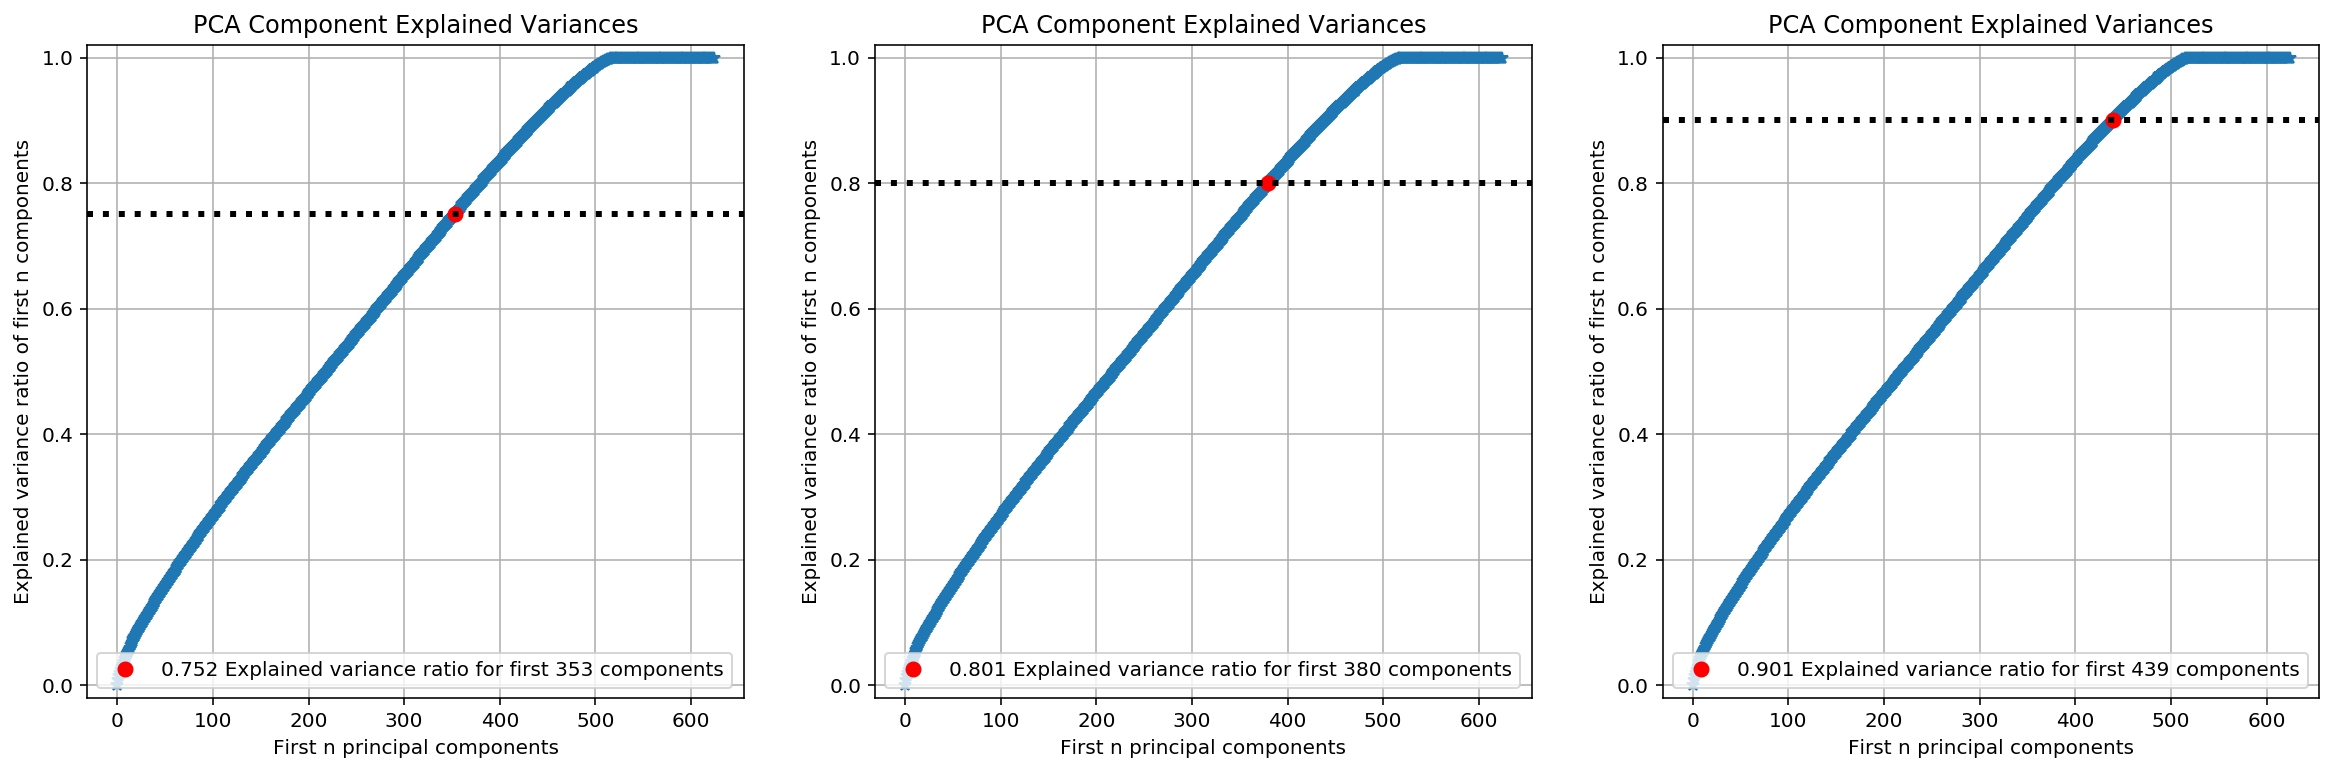

In [137]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
pca = PCA(random_state=1)
pca.fit(Xs_train)
skplt.decomposition.plot_pca_component_variance(pca, ax = ax[0])
skplt.decomposition.plot_pca_component_variance(pca, target_explained_variance=0.8, ax = ax[1])
skplt.decomposition.plot_pca_component_variance(pca, target_explained_variance=0.9, ax = ax[2])

plt.show()

- From the above PCA plots, it can be seen almost 100% of the variance can be explained by the first 500 components therefore I will do PCA with n_components.

In [24]:
pca_model = PCA(n_components= 500)
pca_model.fit(Xs_train)
pca_train = pca_model.transform(Xs_train)
pca_test = pca_model.transform(Xs_test)

In [18]:
pca_model.get_params

<bound method BaseEstimator.get_params of PCA(copy=True, iterated_power='auto', n_components=500, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)>

<a id="logistic"></a>
#### Logistic Regression Model:
---

- Logistic regression is used when the dependent variable is dichotomous (binary).


In [184]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

In [187]:
gs_params = {'penalty': ['l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-6, -1, 10)}

lr_gridsearch = GridSearchCV(lr,
                             gs_params,
                             n_jobs=-1, 
                             cv=3, 
                             verbose=1)

In [188]:
lr_gridsearch.fit(pca_train, y_train)
best_lr = lr_gridsearch.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


In [142]:
dump(best_lr, 'best_lr.joblib')

['best_lr.joblib']

In [190]:
print('Best Params: ',lr_gridsearch.best_params_)
print('Best Train Score: ',lr_gridsearch.best_score_)
print('Best Test Score: ',lr_gridsearch.score(pca_test, y_test))
print('Cross validated score: ', cross_val_score(best_lr, pca_train, y_train, cv=5).mean())

Best Params:  {'C': 0.02782559402207126, 'penalty': 'l2', 'solver': 'liblinear'}
Best Train Score:  0.4790561934917789
Best Test Score:  0.7122993654348637
Cross validated score:  0.44613099666328254


In [147]:
print('Baseline: ', baseline)

Baseline:  0.7109847644990656


In [191]:
lr_predictions = best_lr.predict(pca_test)
confusion = confusion_matrix(y_test, lr_predictions)
pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))

,0,1
0,396,2751
1,332,7237


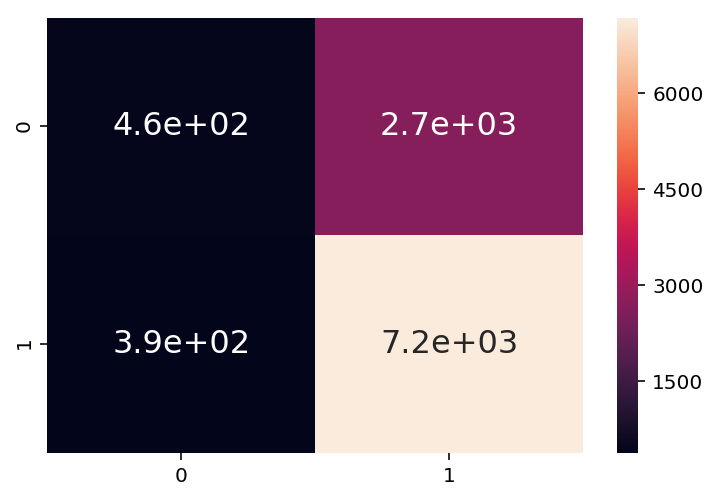

In [229]:
sns.heatmap(pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique())), annot=True,annot_kws={"size": 16})

In [192]:
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.54      0.13      0.20      3147
           1       0.72      0.96      0.82      7569

   micro avg       0.71      0.71      0.71     10716
   macro avg       0.63      0.54      0.51     10716
weighted avg       0.67      0.71      0.64     10716



In [193]:
best_lr.coef_

array([[-5.43220156e-02,  5.63234042e-02,  5.67462062e-02,
         7.92143101e-02,  1.25893062e-02, -9.94911381e-03,
         6.02506023e-02, -4.16446128e-02, -9.80426214e-03,
         9.82750662e-02,  3.14564647e-02, -6.43891913e-02,
         9.07616792e-02, -5.70446944e-02,  7.44285229e-02,
        -9.15438213e-02,  6.38022179e-02,  3.74437178e-03,
         5.11698398e-02, -4.33825809e-02, -1.29762965e-01,
        -2.87212211e-02,  6.39173979e-02, -1.05761334e-01,
        -2.74558944e-02, -4.08181645e-02, -8.11588075e-02,
         9.66909338e-02, -1.44887887e-02,  1.07799932e-01,
         7.46444920e-02,  8.21021358e-02,  4.28402194e-02,
         8.76442922e-02,  3.07472691e-02,  7.27884315e-02,
         3.06185503e-03,  2.10605357e-02,  1.71344036e-02,
         4.15354714e-02,  1.32443853e-02, -5.17293489e-02,
        -2.78636062e-03,  3.20219901e-02, -8.61694619e-02,
         8.31344427e-03,  6.42848546e-02,  7.56237090e-03,
         3.29883734e-01,  1.70475937e-02, -8.99660943e-0

<a id="tree"></a>
#### Decision Tree Classifier:
----

In [197]:
tree = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None, 
                                    random_state=1)

tree_params = {'max_depth':range(1,10)}

treeclass_gs = GridSearchCV(tree,
                             tree_params,
                             n_jobs=-1, 
                             cv=3, 
                             verbose=1)


In [198]:
treeclass_gs.fit(pca_train, y_train)
best_tree = treeclass_gs.best_estimator_
dump(best_tree, 'treeclass.joblib')

print('Best Params: ',treeclass_gs.best_params_)
print('Best Train Score: ',treeclass_gs.score(pca_train, y_train))
print('Best Test Score: ', treeclass_gs.score(pca_test, y_test))
print('Cross Validated Score: ',cross_val_score(best_tree, pca_train, y_train, cv=5).mean())

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.7min finished


Best Params:  {'max_depth': 1}
Best Train Score:  0.7119368252393851
Best Test Score:  0.7063269876819709
Cross Validated Score:  0.6938538510031615


In [199]:
tree_predictions = best_tree.predict(pca_test)
confusion = confusion_matrix(y_test, tree_predictions)
pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))

,0,1
0,0,3147
1,0,7569


In [200]:
print(classification_report(y_test, tree_predictions))

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00      3147\n           1       0.71      1.00      0.83      7569\n\n   micro avg       0.71      0.71      0.71     10716\n   macro avg       0.35      0.50      0.41     10716\nweighted avg       0.50      0.71      0.58     10716\n'

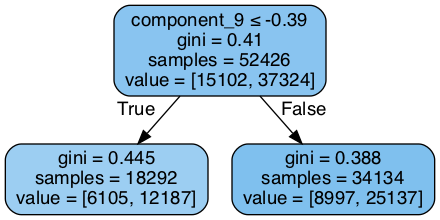

In [203]:
dot_data = StringIO()
export_graphviz(best_tree,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=['component_{}'.format(i) for i in range(pca_train.shape[1])]
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

<a id="bag"></a>
#### Bagging Classifier:
---

In [213]:
bag = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators= 300, verbose = 1, n_jobs = -1)

In [214]:
bag.fit(pca_train, y_train)
dump(bag, 'bagclass.joblib')

print('Best Train Score: ',bag.score(pca_train, y_train))
print('Best Test Score: ', bag.score(pca_test, y_test))
print('Cross Validated Score: ',cross_val_score(bag, pca_train, y_train, cv=5).mean())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 55.5min remaining: 55.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 55.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best Train Score:  0.9925800175485446


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best Test Score:  0.7131392310563643


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 47.8min remaining: 47.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 48.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.0s remaining:    7.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 46.8min remaining: 46.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 46.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.5s remaining:    7.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 65.1min remaining: 65.1min
[Parallel(n_jobs=4)]

KeyboardInterrupt: 

In [215]:
print('Cross Validated Score: ',cross_val_score(bag, pca_train, y_train, cv=5).mean())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 43.8min remaining: 43.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 43.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 39.3min remaining: 39.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 39.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

Cross Validated Score:  0.5639535987299557


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.5s finished


- Best Train Score:  0.9925800175485446
- Best Test Score:  0.7131392310563643
- Cross Validated Score:  0.5639535987299557

In [224]:
bag_predictions = bag.predict(pca_test)
confusion = confusion_matrix(y_test, bag_predictions)
pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.3s finished


,0,1
0,462,2685
1,389,7180


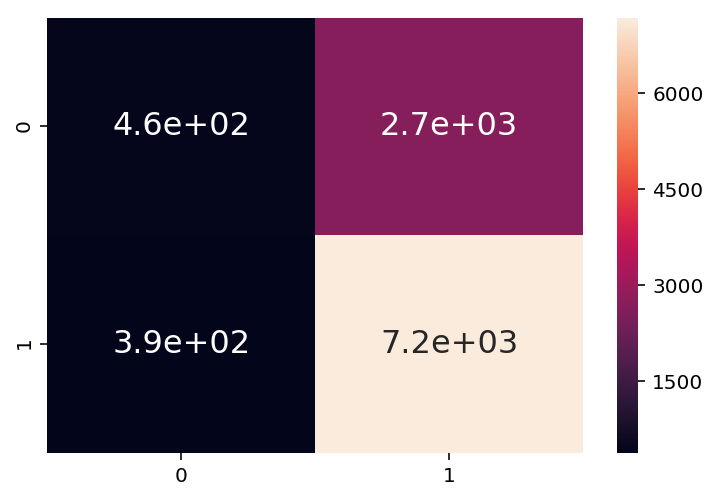

In [228]:
sns.heatmap(pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique())), annot=True,annot_kws={"size": 16})

In [225]:
print(classification_report(y_test, bag_predictions))

              precision    recall  f1-score   support

           0       0.54      0.15      0.23      3147
           1       0.73      0.95      0.82      7569

   micro avg       0.71      0.71      0.71     10716
   macro avg       0.64      0.55      0.53     10716
weighted avg       0.67      0.71      0.65     10716



In [ ]:
# bag_params = {'base_estimator': [DecisionTreeClassifier()], 
#                 'max_samples': np.linspace(0.1,1,5),
#                 'max_features':np.linspace(0.1,1,5)
#                 }
# bag_gs = GridSearchCV(bag,
#                      bag_params,
#                      n_jobs=-1, 
#                      cv=3, 
#                      verbose=1)
# bag_gs.fit(pca_train, y_train)
# best_bag = treeclass_gs.best_estimator_
# dump(best_bag, 'bagclass.joblib')

# print('Best Params: ',bag_gs.best_params_)

<a id="forest"></a>
#### Random Forest Classifier:
---

In [207]:
forest = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=None, max_features='auto', random_state=1)
forest_params = {'max_depth': range(1,15)
                }
forest_gs = GridSearchCV(forest, forest_params, verbose=1, cv=3, n_jobs=-1)

In [208]:
forest_gs.fit(pca_train, y_train)
best_forest = forest_gs.best_estimator_
dump(best_forest, 'forestclass.joblib')

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed: 33.6min finished


['forestclass.joblib']

In [209]:
print('Best params: ', best_forest.get_params)
print('Best train score: ', forest_gs.best_score_)
print('Best test score: ', best_forest.score(pca_test, y_test))
print('Cross validated score: ', cross_val_score(best_forest, pca_train, y_train, cv=5).mean())

Best params:  <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)>
Best train score:  0.7119749742494182
Best test score:  0.7063269876819709
Cross validated score:  0.6930715393961474


In [210]:
forest_predictions = best_forest.predict(pca_test)
confusion = confusion_matrix(y_test, forest_predictions)
pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))

,0,1
0,0,3147
1,0,7569


In [212]:
print(classification_report(y_test, forest_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3147
           1       0.71      1.00      0.83      7569

   micro avg       0.71      0.71      0.71     10716
   macro avg       0.35      0.50      0.41     10716
weighted avg       0.50      0.71      0.58     10716



<a id="knn"></a>
#### KNeighbour Classifier:
---

In [17]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
knn_params = {'n_neighbors': range(3,13),
             'weights': ['uniform','distance']
                }
knn_gs = GridSearchCV(knn, knn_params, verbose=1, cv=5, n_jobs=-1)

knn_gs.fit(pca_train, y_train)
best_knn = knn_gs.best_estimator_
dump(best_knn, 'best_knnclass.joblib')
print('Best params: ', best_knn.get_params)
print('Best train score: ', knn_gs.best_score_)
print('Best test score: ', best_knn.score(pca_test, y_test))
print('Cross validated score: ', cross_val_score(best_knn, pca_train, y_train, cv=5).mean())


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 262.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 714.2min finished


Best params:  <bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')>
Best train score:  0.5699967545484049
Best test score:  0.680081791988103
Cross validated score:  0.569993684099796


In [18]:
knn_predictions = best_knn.predict(pca_test)
confusion = confusion_matrix(y_test, knn_predictions)
pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))


,0,1
0,883,2285
1,1157,6434


In [19]:
classification_report(y_test, knn_predictions)

'              precision    recall  f1-score   support\n\n           0       0.43      0.28      0.34      3168\n           1       0.74      0.85      0.79      7591\n\n   micro avg       0.68      0.68      0.68     10759\n   macro avg       0.59      0.56      0.56     10759\nweighted avg       0.65      0.68      0.66     10759\n'

<a id="oversampling"></a>
### Over-Sampling

---

- We have an imbalanced dataset for the different classes so here i'll be re-sampling the dataset to balance the classes.
- Unfortunately, the score has not improved

In [1]:
balance_pipe = make_pipeline(RandomOverSampler(),LogisticRegression())

pipeline_params = {'logisticregression__penalty': ['l2'],
             'logisticregression__solver': ['liblinear'],
             'logisticregression__C': np.logspace(-3, 3, 6)}


gs_pipeline = GridSearchCV(balance_pipe,
                               pipeline_params,
                               n_jobs=-1, 
                               cv=3, 
                               verbose=1)

gs_pipeline.fit(pca_train, y_train)

In [226]:
print(gs_pipeline.best_score_)
print(gs_pipeline.score(pca_test, y_test))
best_over = gs_pipeline.best_estimator_     
dump(best_over, 'best_overclass.joblib')
print(cross_val_score(best_over, pca_train, y_train, cv = 5).mean())

0.5084500057223516
0.6292459873086973
0.4768564664429021


In [4]:
best_over = load('best_overclass.joblib')

In [25]:
oversamp = best_over.predict(pca_test)
confusion = confusion_matrix(y_test, oversamp)
pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))

,0,1
0,1441,1727
1,3424,4164


In [27]:
print(classification_report(y_test, oversamp))

              precision    recall  f1-score   support

           0       0.30      0.45      0.36      3168
           1       0.71      0.55      0.62      7588

   micro avg       0.52      0.52      0.52     10756
   macro avg       0.50      0.50      0.49     10756
weighted avg       0.59      0.52      0.54     10756

